# Environment Setup

In [7]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import sqrt
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from itertools import combinations
import random
import matplotlib.pyplot as plt
from together import Together
import time
from pydantic import BaseModel, Field


# For tokenization, we reuse Keras' Tokenizer for simplicity.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Using the SentenceTransformer library from Hugging Face for embeddings
from sentence_transformers import SentenceTransformer

# For loading environment variables
from dotenv import load_dotenv
import os

In [8]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Load Data

In [141]:
train_df = pd.read_csv("./data/review.csv")
val_df = pd.read_csv("./data/validation.csv")
test_df = pd.read_csv("./data/prediction.csv")

with open("./data/product.json", "r") as f:
    product_data = json.load(f)
product_df = pd.DataFrame(product_data)

# Data Preprocessing

## Create User Features

In [11]:
grouped_reviews = train_df.groupby('ReviewerID')['Text'] \
                    .agg(' #'.join) \
                    .reset_index(name='combined_reviews')

In [136]:
class User_Feature(BaseModel):
    P_interests: str = Field(description="User's primary interests")
    O_interests: str = Field(description="User's other interests")
    P_intentions: str = Field(description="User's primary intentions")
    O_intentions: str = Field(description="User's other intentions")
    product_preferences: str = Field(description="User's product preferences")

In [13]:
load_dotenv()

TOGETHER_API_KEY = os.getenv('API_KEY')
os.environ["TOGETHER_API_KEY"] = TOGETHER_API_KEY
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"

def analyze_user_reviews(reviews):
    system_prompt = f"""Analyze these user reviews separated by # and identify key characteristics:
    - Primary interests: [a simple noun phrase within 15 words]
    - Other interests: [a simple noun phrase within 15 words]
    - Primary intentions: [a simple verb phrase within 15 words]
    - Other intentions: [a simple verb phrase within 15 words]
    - Preferred product types: [a simple noun phrase within 15 words]
    
    Return as a concise JSON format with these keys: 
    P_interests, O_interests, P_intentions, O_intentions, product_preferences"""
    
    user_prompt = f"Reviews: {reviews}"
    
    client = Together()

    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={
                "type": "json_object",
                "schema": User_Feature.model_json_schema(),
            },
        )

        result = response.choices[0].message.content
        return User_Feature.model_validate_json(result)
        
    except Exception as e:
        print(f"API Error: {e}")
        return None

def process_reviews(grouped_df):
    results = []
    
    for _, row in grouped_df.iterrows():
        analysis = analyze_user_reviews(row['combined_reviews'])
        features = analysis or User_Feature(
            P_interests="Unknown",
            O_interests="Unknown",
            P_intentions="Unknown",
            O_intentions="Unknown",
            product_preferences="Unknown"
        )
        
        results.append({
            "ReviewerID": row['ReviewerID'],
            **features.model_dump()
        })
        
        time.sleep(1)  # Rate limiting
    
    return pd.DataFrame(results)

In [ ]:
# skip this code block if the feature extraction is already done
user_features_df = process_reviews(grouped_reviews)
user_features_df.to_csv("user_features.csv", index=False)

In [137]:
# Load the user features from CSV
user_features_df = pd.read_csv('./user_features.csv')
user_features_df.fillna("Unknown", inplace=True)

## Merge Product Metadata

In [143]:
def extract_main_category(cat_list):
    if not cat_list:
        return "Unknown"
    # Use the last category that is not an HTML artifact.
    last_cat = cat_list[-1]
    if isinstance(last_cat, str) and ('<' in last_cat or '>' in last_cat):
        if len(cat_list) >= 2:
            last_cat = cat_list[-2]
    return last_cat if last_cat else "Unknown"

In [144]:
product_df["MainCategory"] = product_df["category"].apply(extract_main_category)
product_df["BrandClean"] = product_df["brand"].fillna("Unknown")

train_df = train_df.merge(product_df[["ProductID", "MainCategory", "BrandClean"]], on="ProductID", how="left")
val_df = val_df.merge(product_df[["ProductID", "MainCategory", "BrandClean"]], on="ProductID", how="left")
test_df = test_df.merge(product_df[["ProductID", "MainCategory", "BrandClean"]], on="ProductID", how="left")

train_df[["MainCategory", "BrandClean"]] = train_df[["MainCategory", "BrandClean"]].fillna("Unknown")
val_df[["MainCategory", "BrandClean"]] = val_df[["MainCategory", "BrandClean"]].fillna("Unknown")
test_df[["MainCategory", "BrandClean"]] = test_df[["MainCategory", "BrandClean"]].fillna("Unknown")

## Encode IDs and Categorical Features

In [145]:
# User and Product IDs
unique_users = train_df["ReviewerID"].unique().tolist()
unique_items = train_df["ProductID"].unique().tolist()
user_to_index = {u: i+1 for i, u in enumerate(unique_users)}  # reserve 0 for unknown
item_to_index = {p: i+1 for i, p in enumerate(unique_items)}
unknown_user_idx = 0
unknown_item_idx = 0

train_user_idx = train_df["ReviewerID"].apply(lambda x: user_to_index.get(x, unknown_user_idx)).values
train_item_idx = train_df["ProductID"].apply(lambda x: item_to_index.get(x, unknown_item_idx)).values
val_user_idx = val_df["ReviewerID"].apply(lambda x: user_to_index.get(x, unknown_user_idx)).values
val_item_idx = val_df["ProductID"].apply(lambda x: item_to_index.get(x, unknown_item_idx)).values
test_user_idx = test_df["ReviewerID"].apply(lambda x: user_to_index.get(x, unknown_user_idx)).values
test_item_idx = test_df["ProductID"].apply(lambda x: item_to_index.get(x, unknown_item_idx)).values

In [146]:
# Categories and Brands
unique_cats = pd.unique(train_df["MainCategory"]).tolist()
unique_brands = pd.unique(train_df["BrandClean"]).tolist()
cat_to_index = {c: i+1 for i, c in enumerate(unique_cats)}  # 0 for unknown
brand_to_index = {b: i+1 for i, b in enumerate(unique_brands)}
unknown_cat_idx = 0
unknown_brand_idx = 0

train_cat_idx = train_df["MainCategory"].apply(lambda x: cat_to_index.get(x, unknown_cat_idx)).values
train_brand_idx = train_df["BrandClean"].apply(lambda x: brand_to_index.get(x, unknown_brand_idx)).values
val_cat_idx = val_df["MainCategory"].apply(lambda x: cat_to_index.get(x, unknown_cat_idx)).values
val_brand_idx = val_df["BrandClean"].apply(lambda x: brand_to_index.get(x, unknown_brand_idx)).values
test_cat_idx = test_df["MainCategory"].apply(lambda x: cat_to_index.get(x, unknown_cat_idx)).values
test_brand_idx = test_df["BrandClean"].apply(lambda x: brand_to_index.get(x, unknown_brand_idx)).values

## User Feature Embeddings

In [153]:
# can skip this code block if the embedding is already done
text_model = SentenceTransformer('all-MiniLM-L6-v2') 

user_features_df["User_features"] = "Primary interests: " + user_features_df["P_interests"] + \
    ", Other interests: " + user_features_df["O_interests"] + \
    ", Primary intentions: " + user_features_df["P_intentions"] + \
    ", Other intentions: " + user_features_df["O_intentions"] + \
    ", Product preferences: " + user_features_df["product_preferences"]

with torch.no_grad():
    user_index_to_features_embed = {
        user_to_index.get(row['ReviewerID'], unknown_user_idx): text_model.encode(row['User_features'])
        for _, row in user_features_df.iterrows()
    }

user_index_to_features_embed[0] = text_model.encode("Unknown")  # Unknown user features
torch.save(user_index_to_features_embed, "./weights/mapping/user_index_to_features_embed.pth")

## Text Tokenization

In [15]:
# Use the "Text" column from training data. (If you wish, you can also combine "Summary".)
train_texts = train_df["Text"].fillna("").astype(str).tolist()
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
MAX_SEQ_LEN = 100
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# For validation and test, assume no review text is provided (or use empty strings)
val_padded = np.zeros((len(val_df), MAX_SEQ_LEN), dtype=int)
test_padded = np.zeros((len(test_df), MAX_SEQ_LEN), dtype=int)

## Prepare Target Ratings

In [156]:
train_ratings = train_df["Star"].values.astype(np.float32)
val_ratings = val_df["Star"].values.astype(np.float32)

# Create a PyTorch Dataset

In [157]:
class RatingDataset(Dataset):
    # def __init__(self, user_ids, item_ids, text_seqs, cat_ids, brand_ids, ratings):
    def __init__(self, user_ids, item_ids, cat_ids, brand_ids, ratings):
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)
        self.item_ids = torch.tensor(item_ids, dtype=torch.long)
        # self.text_seqs = torch.tensor(text_seqs, dtype=torch.long)
        self.cat_ids = torch.tensor(cat_ids, dtype=torch.long)
        self.brand_ids = torch.tensor(brand_ids, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)
        
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        return (self.user_ids[idx],
                self.item_ids[idx],
                # self.text_seqs[idx],
                self.cat_ids[idx],
                self.brand_ids[idx],
                self.ratings[idx])
                
train_dataset = RatingDataset(train_user_idx, train_item_idx, train_cat_idx, train_brand_idx, train_ratings)
val_dataset = RatingDataset(val_user_idx, val_item_idx, val_cat_idx, val_brand_idx, val_ratings)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define the Model in PyTorch

In [158]:
class RatingPredictor(nn.Module):
    # def __init__(self, num_users, num_items, vocab_size, num_cats, num_brands, max_seq_len,
    #              user_emb_dim=128, item_emb_dim=256, word_emb_dim=100, cat_emb_dim=128, brand_emb_dim=128, hidden_dim=512):
    def __init__(self, num_users, num_items, num_cats, num_brands,
                 user_emb_dim=128, item_emb_dim=256, cat_emb_dim=128, brand_emb_dim=128, hidden_dim=512):
        super(RatingPredictor, self).__init__()
        # Embedding layers
        self.user_emb = nn.Embedding(num_users, user_emb_dim, padding_idx=0)
        self.item_emb = nn.Embedding(num_items, item_emb_dim, padding_idx=0)
        # self.word_emb = nn.Embedding(vocab_size, word_emb_dim)
        self.cat_emb = nn.Embedding(num_cats, cat_emb_dim, padding_idx=0)
        self.brand_emb = nn.Embedding(num_brands, brand_emb_dim, padding_idx=0)
                
        # # Combined feature dimension: user + item + text features (3*50 = 150) + category + brand
        # combined_dim = user_emb_dim + item_emb_dim + 150 + cat_emb_dim + brand_emb_dim
        # Combined feature dimension: user + item + user features + category + brand
        combined_dim = user_emb_dim + item_emb_dim + 384 + cat_emb_dim + brand_emb_dim
        self.ln1 = nn.LayerNorm(combined_dim)
        self.fc_in = nn.Linear(combined_dim, hidden_dim)
        # self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.ln3 = nn.LayerNorm(hidden_dim//2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim//2, hidden_dim//4)
        # Final output layer with scaled sigmoid so predictions fall in [1,5]
        self.fc_out = nn.Linear(hidden_dim//4, 1)
        
    # def forward(self, user_ids, item_ids, text_seq, cat_ids, brand_ids):
    def forward(self, user_ids, item_ids, cat_ids, brand_ids, user_feature_embed):
        # Get embeddings for user and item
        user_vec = self.user_emb(user_ids)       # (batch, user_emb_dim)
        item_vec = self.item_emb(item_ids)         # (batch, item_emb_dim)
        
        # Process review text
        # text_seq: (batch, max_seq_len) -> word embeddings: (batch, max_seq_len, word_emb_dim)
        # text_emb = self.word_emb(text_seq)         # (batch, max_seq_len, word_emb_dim)
        # text_emb = text_emb.transpose(1, 2)         # (batch, word_emb_dim, max_seq_len)
        
        # Apply three parallel convolutions with different kernel sizes
        # conv3 = F.relu(self.conv1d_3(text_emb))     # (batch, 50, L3)
        # pool3 = self.pool(conv3).squeeze(-1)         # (batch, 50)
        
        # conv4 = F.relu(self.conv1d_4(text_emb))     # (batch, 50, L4)
        # pool4 = self.pool(conv4).squeeze(-1)         # (batch, 50)
        
        # conv5 = F.relu(self.conv1d_5(text_emb))     # (batch, 50, L5)
        # pool5 = self.pool(conv5).squeeze(-1)         # (batch, 50)
        
        # Concatenate text features from all kernels
        # text_features = torch.cat([pool3, pool4, pool5], dim=1)  # (batch, 150)
        
        # Get metadata embeddings
        cat_vec = self.cat_emb(cat_ids)             # (batch, cat_emb_dim)
        brand_vec = self.brand_emb(brand_ids)         # (batch, brand_emb_dim)

        # Get user feature embeddings
        user_feature_vec = user_feature_embed(user_ids)  # (batch, 384)
        
        # Concatenate all features
        # combined = torch.cat([user_vec, item_vec, text_features, cat_vec, brand_vec], dim=1)
        combined = torch.cat([user_vec, user_feature_vec, item_vec, cat_vec, brand_vec], dim=1)
        
        # Fully connected layers with BatchNorm and Dropout
        x = self.fc_in(self.ln1(combined))
        x = F.leaky_relu(self.fc1(self.dropout1(self.ln2(x))), 0.1) 
        x = F.leaky_relu(self.fc2(self.dropout2(self.ln3(x))), 0.1)
        # Use a scaled sigmoid so that outputs are between 1 and 5.
        out = 1 + 4 * torch.sigmoid(self.fc_out(x))
        return out.squeeze(1)

In [159]:
# Define sizes (add +1 to account for unknown index 0)
num_users = len(user_to_index) + 1
num_items = len(item_to_index) + 1
# vocab_size = min(10000, len(tokenizer.word_index) + 1)
num_cats = len(cat_to_index) + 1
num_brands = len(brand_to_index) + 1

model = RatingPredictor(num_users, num_items, num_cats, num_brands)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RatingPredictor(
  (user_emb): Embedding(2800, 128, padding_idx=0)
  (item_emb): Embedding(6639, 256, padding_idx=0)
  (cat_emb): Embedding(38, 128, padding_idx=0)
  (brand_emb): Embedding(3618, 128, padding_idx=0)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc_in): Linear(in_features=1024, out_features=512, bias=True)
  (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (ln3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

# Training

## Training Setup

In [160]:
# Training setting
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.01
LR_WARMUP = 5
NUM_EPOCHS = 20


In [161]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# warmup_lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: e / LR_WARMUP if e < LR_WARMUP else 1)
# train_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS-LR_WARMUP, eta_min=1e-6)
# lr_scheduler = optim.lr_scheduler.SequentialLR(optimizer, [warmup_lr_scheduler, train_lr_scheduler], milestones=[LR_WARMUP])


In [162]:
user_index_to_features_embed = torch.load("./weights/mapping/user_index_to_features_embed.pth", weights_only=False)
user_feature_embed = nn.Embedding.from_pretrained(torch.stack([torch.tensor(user_index_to_features_embed[i]) for i in range(len(user_index_to_features_embed))], dim=0), freeze=True).to(device)

In [163]:
def evaluate(model, loader, user_feature_embed):
    model.eval()
    losses = []
    preds = []
    trues = []
    with torch.no_grad():
        for batch in loader:
            # user_ids, item_ids, text_seqs, cat_ids, brand_ids, ratings = batch
            user_ids, item_ids, cat_ids, brand_ids, ratings = batch
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            # text_seqs = text_seqs.to(device)
            cat_ids = cat_ids.to(device)
            brand_ids = brand_ids.to(device)
            ratings = ratings.to(device)
            outputs = model(user_ids, item_ids, cat_ids, brand_ids, user_feature_embed)
            loss = criterion(outputs, ratings)
            losses.append(loss.item() * ratings.size(0))
            preds.extend(outputs.cpu().numpy())
            trues.extend(ratings.cpu().numpy())
    avg_loss = np.sum(losses) / len(loader.dataset)
    rmse_val = sqrt(np.mean((np.array(preds) - np.array(trues)) ** 2))
    return avg_loss, rmse_val

## Training Loop

In [164]:
train_losses = []
train_rmses = []   
val_losses = []
val_rmses = []
lrs = []
best_val_loss = float('inf')
model_name = "model_layernorm"
best_model_path = "./model/" + model_name + ".pth"

# Early stopping parameters
patience = 5
epochs_no_improve = 0


for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        # user_ids, item_ids, text_seqs, cat_ids, brand_ids, ratings = batch
        user_ids, item_ids, cat_ids, brand_ids, ratings = batch
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        # text_seqs = text_seqs.to(device)
        cat_ids = cat_ids.to(device)
        brand_ids = brand_ids.to(device)
        ratings = ratings.to(device)
        
        optimizer.zero_grad()
        outputs = model(user_ids, item_ids, cat_ids, brand_ids, user_feature_embed)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * ratings.size(0)
        
    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_rmse = evaluate(model, val_loader, user_feature_embed)
    train_losses.append(train_loss)
    train_rmses.append(sqrt(train_loss))
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    # lrs.append(lr_scheduler.get_last_lr()[0])
    # lr_scheduler.step()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -- Train Loss: {train_loss:.4f}  Train RMSE: {sqrt(train_loss):.4f} Val Loss: {val_loss:.4f}  Val RMSE: {val_rmse:.4f}")

    # Save checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'rmse': val_rmse,
        }, best_model_path)
        print(f'Checkpoint saved at epoch {epoch+1} with validation rmse {val_rmse:.4f}')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {patience} epochs without improvement.')
            break

Epoch 1/20 -- Train Loss: 0.8125  Train RMSE: 0.9014 Val Loss: 0.8742  Val RMSE: 0.9350
Checkpoint saved at epoch 1 with validation rmse 0.9350
Epoch 2/20 -- Train Loss: 0.6031  Train RMSE: 0.7766 Val Loss: 0.7526  Val RMSE: 0.8675
Checkpoint saved at epoch 2 with validation rmse 0.8675
Epoch 3/20 -- Train Loss: 0.5108  Train RMSE: 0.7147 Val Loss: 0.7260  Val RMSE: 0.8521
Checkpoint saved at epoch 3 with validation rmse 0.8521
Epoch 4/20 -- Train Loss: 0.4642  Train RMSE: 0.6813 Val Loss: 0.7401  Val RMSE: 0.8603
Epoch 5/20 -- Train Loss: 0.4340  Train RMSE: 0.6588 Val Loss: 0.7213  Val RMSE: 0.8493
Checkpoint saved at epoch 5 with validation rmse 0.8493
Epoch 6/20 -- Train Loss: 0.4117  Train RMSE: 0.6416 Val Loss: 0.7510  Val RMSE: 0.8666
Epoch 7/20 -- Train Loss: 0.3922  Train RMSE: 0.6262 Val Loss: 0.7787  Val RMSE: 0.8825
Epoch 8/20 -- Train Loss: 0.3790  Train RMSE: 0.6157 Val Loss: 0.7672  Val RMSE: 0.8759
Epoch 9/20 -- Train Loss: 0.3663  Train RMSE: 0.6052 Val Loss: 0.7470  V

## Visualization

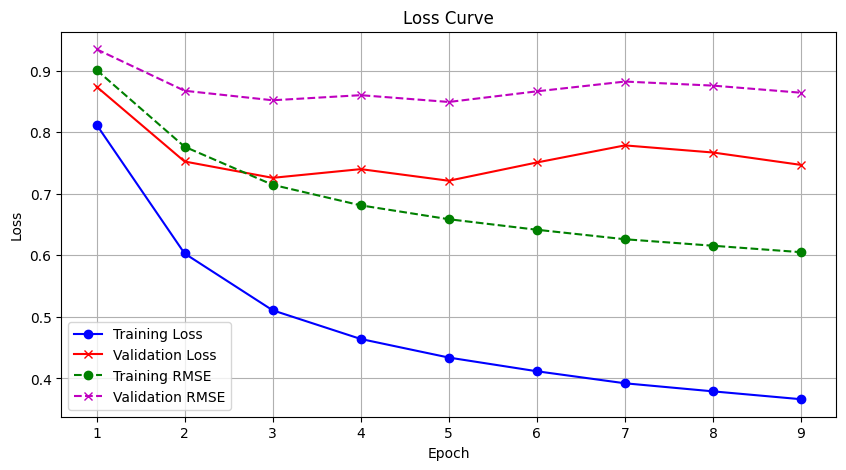

<Figure size 640x480 with 0 Axes>

In [166]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', linestyle='-', color='r', label='Validation Loss')
plt.plot(range(1, len(train_rmses) + 1), train_rmses, marker='o', linestyle='--', color='g', label='Training RMSE')
plt.plot(range(1, len(val_rmses) + 1), val_rmses, marker='x', linestyle='--', color='m', label='Validation RMSE')
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

plt.savefig("./picture/Loss_Curve_" + model_name + ".png")

# Generate Predictions

In [172]:
def generate_predictions(model, user_ids, item_ids, cat_ids, brand_ids, user_feature_embed):
    model.eval()
    inputs = {
        "user_ids": torch.tensor(user_ids, dtype=torch.long).to(device),
        "item_ids": torch.tensor(item_ids, dtype=torch.long).to(device),
        # "text_seqs": torch.tensor(text_seqs, dtype=torch.long).to(device),
        "text_seqs": None,
        "cat_ids": torch.tensor(cat_ids, dtype=torch.long).to(device),
        "brand_ids": torch.tensor(brand_ids, dtype=torch.long).to(device)
    }
    with torch.no_grad():
        preds = model(inputs["user_ids"], inputs["item_ids"],
                      inputs["cat_ids"], inputs["brand_ids"], user_feature_embed)
    return preds.cpu().numpy()

In [44]:
# load the best model
checkpoint = torch.load(best_model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Validation set

In [176]:
# Predictions for validation set
val_preds = generate_predictions(model, val_user_idx, val_item_idx, val_cat_idx, val_brand_idx, user_feature_embed)
# Compute RMSE manually (or use evaluate.py later)
val_rmse = sqrt(np.mean((val_preds - val_ratings) ** 2))
print(f"Final Validation RMSE: {val_rmse:.4f}")

Final Validation RMSE: 0.7992


In [177]:
# Save validation predictions to CSV (for evaluate.py)
val_pred_df = pd.DataFrame({
    "ReviewerID": val_df["ReviewerID"],
    "ProductID": val_df["ProductID"],
    "Star": val_preds
})

if not os.path.exists("./prediction/" + model_name + "/"):
    os.makedirs("./prediction/" + model_name + "/")

val_pred_df.to_csv("./prediction/" + model_name + "/validation_prediction.csv", index=False)

## Test set

In [178]:
# Predictions for test set
test_preds = generate_predictions(model, test_user_idx, test_item_idx, test_cat_idx, test_brand_idx, user_feature_embed)
test_pred_df = pd.DataFrame({
    "ReviewerID": test_df["ReviewerID"],
    "ProductID": test_df["ProductID"],
    "Star": test_preds
})

test_pred_df.to_csv("./prediction/" + model_name + "/prediction.csv", index=False)
print("Saved validation_prediction.csv and prediction.csv")

Saved validation_prediction.csv and prediction.csv
